In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D

mnist_data = tv.datasets.MNIST(root=os.getcwd(),
                               download=True,
                               transform=tv.transforms.ToTensor())

kmnist_data = tv.datasets.KMNIST(root=os.getcwd(),
                                 download=True,
                                 transform=tv.transforms.ToTensor())

# Dataset at http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar
kanji_data = tv.datasets.DatasetFolder(
    root=os.getcwd() + '/kkanji2',
    loader=PIL.Image.open,
    extensions=('.png'),
    transform=tv.transforms.Compose([
        tv.transforms.Grayscale(num_output_channels=1),
        tv.transforms.ToTensor()]
    )
)

class VAE(nn.Module):
    def __init__(self, img_width, dim_z, device):
        super().__init__()
        
        self.c = 64 # No. output channels of the first convolution
        c = self.c
        fc_input_dim = self.c * 2 * (img_width // 4) ** 2
        
        # Encoder parameters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(fc_input_dim, dim_z)
        self.fc2 = nn.Linear(fc_input_dim, dim_z)
        
        # Decoder parameters
        self.fc3 = nn.Linear(dim_z, fc_input_dim)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        
        # Define the prior distribution for p(z) as N(0,I)
        self.prior = D.Normal(torch.zeros(dim_z).to(device), torch.ones(dim_z).to(device))
        
        self.to(device)
    
    def encode(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.flatten(start_dim=1)
        mu = self.fc1(x)
        logvar = self.fc2(x) # log sigma^2
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        z = torch.relu(self.fc3(z))
        z = z.view(z.shape[0], self.c*2, img_width//4, img_width//4)
        z = torch.relu(self.conv3(z))
        probs = torch.sigmoid(self.conv4(z))
        return probs
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, target, output, mu, logvar):
        logprob = D.ContinuousBernoulli(probs=output).log_prob(target).sum()
        DKL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = -logprob + DKL
        return loss, logprob.detach().item(), DKL.detach().item()
    
    def sample(self, z=None, prior=None):
        with torch.no_grad():
            if prior is not None:
                z = prior.sample().unsqueeze(dim=0)
            elif z is None:
                z = self.prior.sample().unsqueeze(dim=0)
            return self.decode(z)

# Make a grid from a batch of images.
# The batch must have shape [n_rows * n_cols, 1, img_width, img_width]
def plot_grid(batch, img_width, n_rows, cmap="gray", fname=None, figsize=12):
    pics = batch.reshape([-1, img_width]).split(img_width)
    cols, i = [], 0
    while i < len(pics):
        col = torch.cat(pics[i:i+n_rows])
        cols.append(col)
        i += n_rows
    grid = torch.cat(cols, dim=1).to('cpu')
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    plt.imshow(grid, cmap=cmap)
    if fname:
        plt.imsave(fname, grid, cmap=cmap)

In [ ]:
dataset = kanji_data
img_width = 64
dim_z = 64 # code size
epochs = 100
batch_size = 128
use_gpu = True

device = torch.device("cuda" if use_gpu else "cpu")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
vae = VAE(img_width, dim_z, device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(epochs):
    n_batches = 0
    sum_logp, sum_dkl = 0, 0
    for batch, _ in dataloader:
        optimizer.zero_grad()
        targets = batch.to(device)
        out, mu, logvar = vae(targets)
        loss, logp, dkl = vae.loss(targets, out, mu, logvar)
        loss.backward()
        optimizer.step()
        
        n_batches += 1
        sum_logp += logp
        sum_dkl += dkl
        
    print('EPOCH {:3d}\tLOGP {:.0f}\tDKL {:.0f}'.format(epoch+1, sum_logp/n_batches, sum_dkl/n_batches))

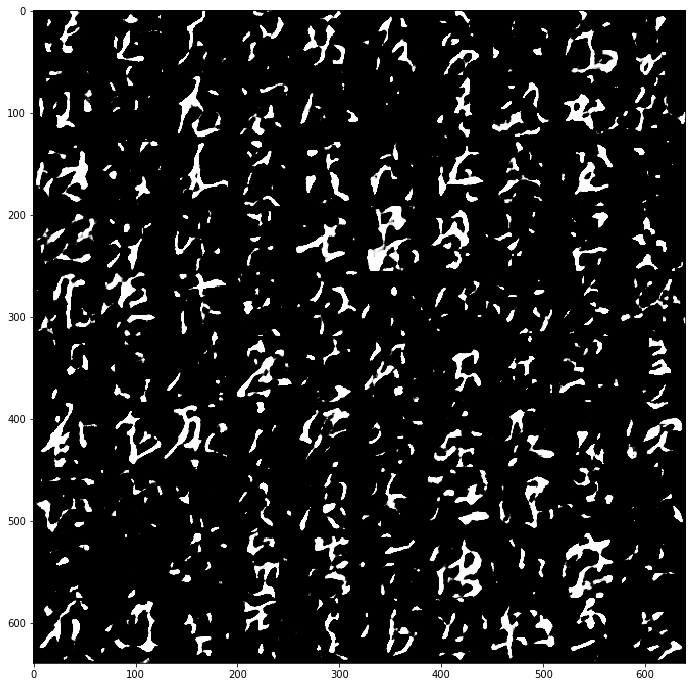

In [42]:
# Make a grid of images decoded from samples of the prior
rows, cols = 10, 10
batch = torch.cat([vae.sample() for _ in range(rows * cols)])
plot_grid(batch, img_width, rows, cmap="gray", figsize=12)

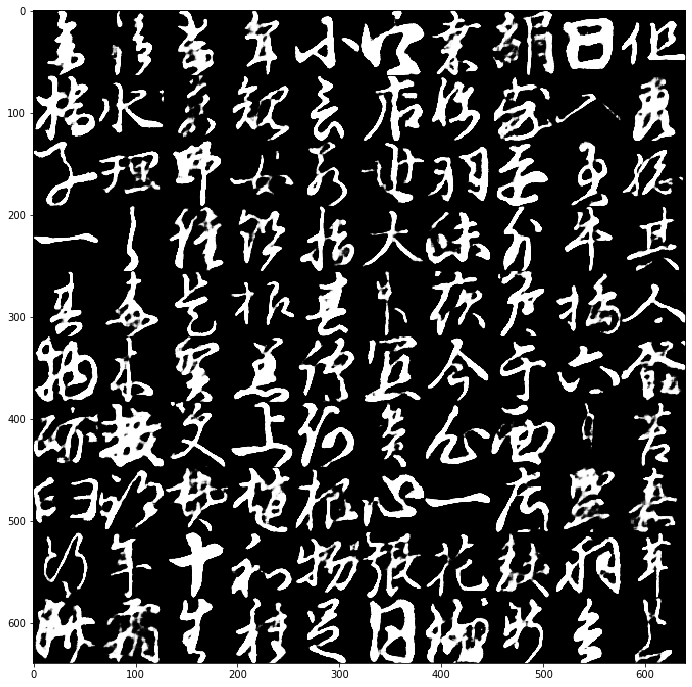

In [51]:
# Make a grid of reconstructed examples
n_rows = 10
for batch, _ in dataloader:
    batch = batch[:n_rows**2].to(device)
    break
with torch.no_grad():
    grid, _, _ = vae(batch)
plot_grid(grid, img_width, n_rows, cmap="gray", figsize=12)

In [6]:
# Map points in the latent space to a grid
# This can only be done with a two dimensional latent space
if dim_z == 2:
    n_rows = 25
    z_scale = 1.8
    latents = torch.linspace(-z_scale, z_scale, n_rows)
    latent_batch = torch.FloatTensor(n_rows, n_rows, 2)
    for i in range(n_rows):
        for j in range(n_rows):
            latent_batch[i][j][0] = latents[i]
            latent_batch[i][j][1] = latents[j]
    latent_batch = latent_batch.view(-1, 2).to(device)
    out = vae.sample(z=latent_batch)
    plot_grid(out, img_width, n_rows, figsize=15, cmap="plasma")